In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
import re
import torch
from sentence_transformers import SentenceTransformer
from transformers import  RobertaForSequenceClassification, RobertaTokenizer, Trainer
import datasets
import hdbscan
import os
from statistics import mean, median
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook      

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
device

'cuda'

In [3]:
tweets = pd.read_csv('../data/uk_mps.csv', sep=',')
len(tweets)

258184

In [4]:
tweets['date'] = pd.to_datetime(tweets.created_at, format='%Y-%m-%d')
tweets = tweets[(tweets['date'] >= '2021-09-02') & (tweets['date'] < '2022-01-03')]
len(tweets)

257149

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


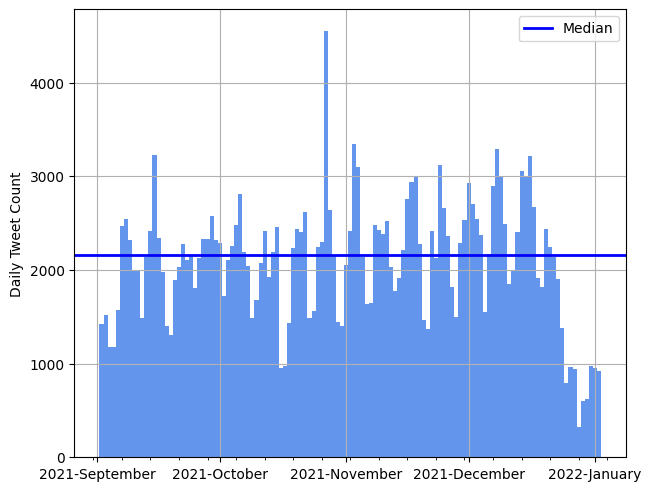

In [5]:
tweets['date'] = tweets['date'].dt.date
daily_counts =  tweets.groupby(by='date').size()
count_median = daily_counts.median()

bar_width = 1
fig, axs = plt.subplots(constrained_layout=True)
plt.bar(daily_counts.index, daily_counts, bar_width,  color='cornflowerblue')

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%Y-%B')
axs.xaxis.set_major_locator(months)
axs.xaxis.set_major_formatter(months_fmt)
days = mdates.DayLocator(interval=7)
axs.xaxis.set_minor_locator(days)
axs.axhline(count_median, color='blue', linewidth=2, label='Median')
axs.grid(True)
axs.set_ylabel(r'Daily Tweet Count')
plt.legend()
plt.savefig('../data/dailycount_raw.eps', format='eps')

In [6]:
tweets = tweets[tweets['full_text'].str.contains('RT')==False]
len(tweets)

120712

In [7]:
tweets.drop_duplicates(subset=['full_text'], keep = False, inplace = True)
len(tweets)

120419

In [8]:
#remove urls
tweets['text_processed'] = tweets['full_text'].map(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x))
#remove mentions
tweets['text_processed'] = tweets['text_processed'].map(lambda x: re.sub(r'[^A-Za-zÀ-ž ]', '', x))
tweets['text_processed'] = tweets['text_processed'].map(lambda x: re.sub(r'(@[A-Za-z0-9]+)', '', x))
#remove and lowercase
tweets['text_processed_cluster'] = tweets['text_processed'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))
#drop empty rows
tweets['text_processed'].replace('', np.nan, inplace=True)
tweets.dropna(subset=['text_processed'], inplace=True)
tweets['text_processed_cluster'].replace('', np.nan, inplace=True)
tweets.dropna(subset=['text_processed_cluster'], inplace=True)
len(tweets)

118862

In [9]:
tweets_per_party = tweets.groupby('Party')['Party'].count()
tweets_per_party

Party
Alliance Party of Northern Ireland      225
Conservative                          39035
Democratic Unionist Party               383
Green Party                             645
Independent                             755
Labour                                57948
Liberal Democrat                       3395
Plaid Cymru                             530
Scottish National Party               14097
Sinn Féin                               619
Social Democratic and Labour Party      617
Speaker                                  90
Name: Party, dtype: int64

In [10]:
tweets = tweets[tweets.Party.isin(['Conservative', 'Liberal Democrat', 'Labour', 'Scottish National Party'])]
len(tweets)

114475

In [11]:
noisy_dataset = datasets.Dataset.from_pandas(tweets)
model = RobertaForSequenceClassification.from_pretrained('../results/roberta_base_arg_20').to(device)
trainer = Trainer(model=model)
tokenizer = RobertaTokenizer.from_pretrained('../results/roberta_base_arg_20')
tokenize = lambda sentences: tokenizer(sentences['text_processed_cluster'], padding='max_length', truncation=True)
tok_noisy_dataset = noisy_dataset.map(tokenize, batched=True)
prediction = trainer.predict(tok_noisy_dataset)
tweets['argumentative'] = prediction.predictions.argmax(-1)
tweets = tweets[tweets['argumentative']==1]

loading file vocab.json
loading file merges.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


  0%|          | 0/115 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, Constituency, id, user_name, created_at, full_text, Party, date, text_processed_cluster, id_str, text_processed, user_followers_count, user_id, user_screen_name. If __index_level_0__, Constituency, id, user_name, created_at, full_text, Party, date, text_processed_cluster, id_str, text_processed, user_followers_count, user_id, user_screen_name are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 114475
  Batch size = 8


  0%|          | 0/14310 [00:00<?, ?it/s]

In [12]:
len(tweets)

34998

In [16]:
tweets_per_party = tweets.groupby('Party')['Party'].count()
tweets_per_party

Party
Conservative               12974
Labour                     18236
Liberal Democrat            1267
Scottish National Party     2521
Name: Party, dtype: int64

In [18]:
if round(len(tweets)/50) < 3:
    min_topic_size = 3
else: 
    min_topic_size = round(len(tweets)/50)
from bertopic import BERTopic
combined_df = pd.DataFrame()
umap_model = UMAP(random_state=42, n_components=5, min_dist=0.0, metric='cosine')
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words='english')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_topic_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
embedding_model = SentenceTransformer('all-mpnet-base-v2')

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, umap_model=umap_model, vectorizer_model=vectorizer_model, min_topic_size=min_topic_size, verbose=True, calculate_probabilities=True, nr_topics='auto')

loading configuration file C:\Users\pEhne/.cache\torch\sentence_transformers\sentence-transformers_all-mpnet-base-v2\config.json
Model config MPNetConfig {
  "_name_or_path": "C:\\Users\\pEhne/.cache\\torch\\sentence_transformers\\sentence-transformers_all-mpnet-base-v2\\",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.25.1",
  "vocab_size": 30527
}

loading weights file C:\Users\pEhne/.cache\torch\sentence_transformers\sentence-transformers_all-mpnet-base-v2\pytorch_model.bin
All model checkpoint weights were used when initializing MPNetModel.

In [19]:
topics, probabilities = topic_model.fit_transform(tweets['text_processed_cluster'].to_list())

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

2023-02-09 17:58:32,153 - BERTopic - Transformed documents to Embeddings
2023-02-09 17:59:18,416 - BERTopic - Reduced dimensionality
2023-02-09 17:59:32,107 - BERTopic - Clustered reduced embeddings
2023-02-09 17:59:43,497 - BERTopic - Reduced number of topics from 10 to 10


In [20]:
topics_list = topic_model.get_topics()

In [22]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,16559,-1_amp_support_people_government
1,0,3413,0_care_tax_social_universal
2,1,2634,1_great_local_work_amp
3,2,2445,2_climate_cop_energy_green
4,3,2379,3_uk_amp_people_trade
5,4,2286,4_women_violence_police_girls
6,5,2143,5_covid_vaccine_booster_vaccines
7,6,1588,6_rules_mps_tory_corruption
8,7,849,7_rail_transport_services_north
9,8,702,8_remember_remembrance_service_armed


In [24]:
tweets['probabilities'] = [sorted(((value, index) for index, value in enumerate(probs)), reverse=True)[:1] for probs in probabilities]
tweets['probabilities'] = tweets['probabilities'].map(lambda x: x[0][1])

In [25]:
tweets.to_csv('../datasets/tweet_corpus_2percent_arg.csv', encoding='utf8',sep='\t', index=False)

In [26]:
topic_model.save('../results/topic_model_2percent_arg')